In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score,RandomizedSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance 
import matplotlib.pyplot as plt
import seaborn as sns


Loading Data

In [7]:
df = pd.read_csv("StudentsPerformance.csv")
print("dataFrameset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (1000, 8)

Missing values:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

First few rows:
   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none        

EDA

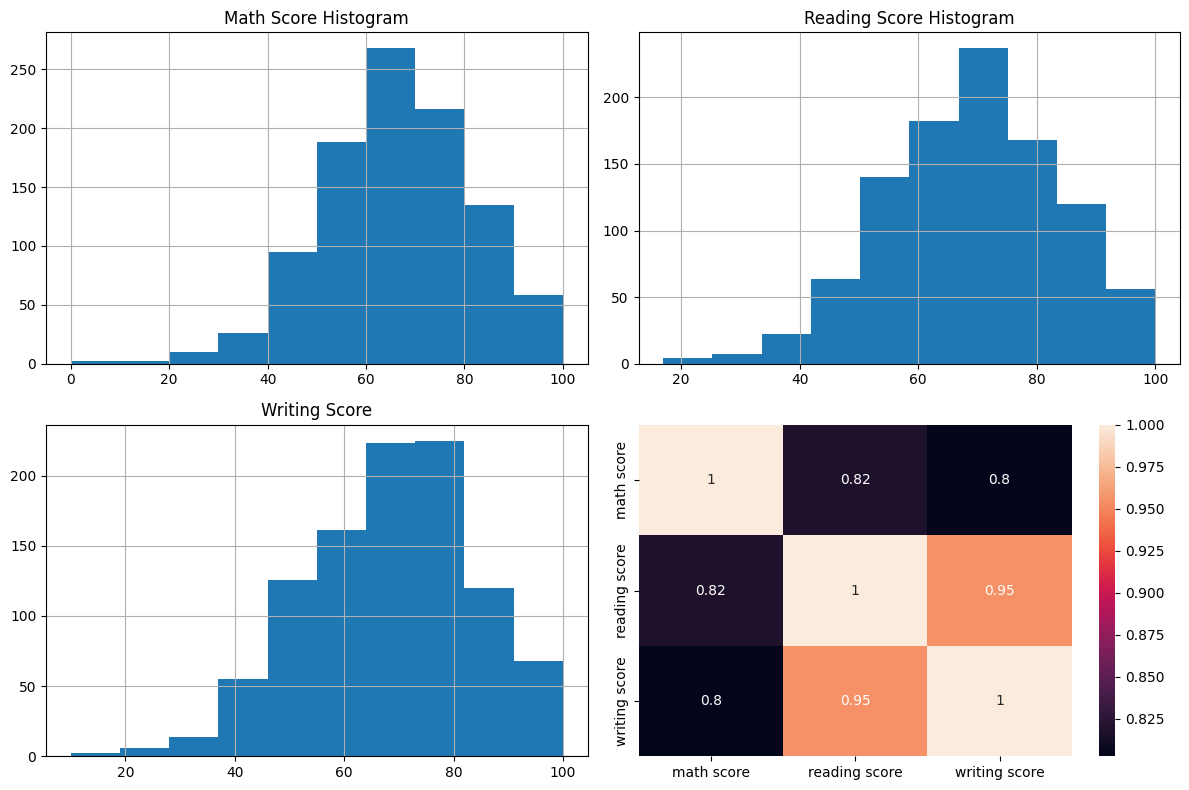

In [8]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
df['math score'].hist(ax=axes[0,0])
axes[0,0].set_title("Math Score Histogram")

df['reading score'].hist(ax=axes[0,1])
axes[0,1].set_title("Reading Score Histogram")

df['writing score'].hist(ax=axes[1,0])
axes[1,0].set_title("Writing Score")
sns.heatmap(df.corr(numeric_only=True), annot=True, ax=axes[1,1])
plt.tight_layout()
plt.savefig('eda_plots.png')

Feature Engineering

In [30]:
X = df.drop('writing score', axis=1)
y = df['writing score']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

def add_features(dataFrame):
    dataFrame = dataFrame.copy()
    dataFrame['average_score'] = (dataFrame['math score'] + dataFrame['reading score']) / 2
    dataFrame['score_difference'] = dataFrame['math score'] - dataFrame['reading score']
    dataFrame['score_ratio'] = dataFrame['reading score'] / (dataFrame['math score'] + 1e-7)
    dataFrame['total_score'] = dataFrame['math score'] + dataFrame['reading score']
    dataFrame['math_squared'] = dataFrame['math score'] ** 2
    dataFrame['reading_squared'] = dataFrame['reading score'] ** 2
    dataFrame['score_product'] = dataFrame['math score'] * dataFrame['reading score']
    
    return dataFrame

x_train = add_features(x_train)
x_test = add_features(x_test)

print(x_train.columns.tolist())







['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'average_score', 'score_difference', 'score_ratio', 'total_score', 'math_squared', 'reading_squared', 'score_product']


Scaler

In [31]:
cat_cols = x_train.select_dtypes(include=['object']).columns
num_cols = x_train.select_dtypes(include=['int64', 'float64']).columns

x_train[cat_cols] = x_train[cat_cols].astype('category')
x_test[cat_cols] = x_test[cat_cols].astype('category')

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[num_cols])
x_test_scaled = scaler.transform(x_test[num_cols])

x_train_num_scaled = pd.DataFrame(x_train_scaled, columns=num_cols, index=x_train.index)
x_test_num_scaled = pd.DataFrame(x_test_scaled, columns=num_cols, index=x_test.index)

X_train_final = pd.concat([x_train_num_scaled, x_train[cat_cols]], axis=1)
X_test_final = pd.concat([x_test_num_scaled, x_test[cat_cols]], axis=1)




Baseline 
Model

In [36]:
baseline_model = XGBRegressor(
    random_state = 42,
    enable_categorical=True,
    tree_method = "hist"
)
baseline_model.fit(X_train_final, y_train)
y_pred_baseline_train = baseline_model.predict(X_train_final)
y_pred_baseline_test = baseline_model.predict(X_test_final)


baseline_train_r2 = r2_score(y_train, y_pred_baseline_train)
baseline_test_r2 = r2_score(y_test, y_pred_baseline_test)
baseline_test_rmse = root_mean_squared_error(y_test, y_pred_baseline_test)

print(f"Baseline Train R²: {baseline_train_r2:.4f}")
print(f"Baseline Test R²: {baseline_test_r2:.4f}")
print(f"Baseline Test RMSE: {baseline_test_rmse:.4f}")

Baseline Train R²: 0.9994
Baseline Test R²: 0.9184
Baseline Test RMSE: 4.4356


HyperParametre and Outcome


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best CV R² Score: 0.9423
Best Parameters: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.6}

--- Performance Comparison ---
Baseline Test R²:     0.9184
Tuned Model Test R²:  0.9327
Improvement:          0.0143

--- Final Model Metrics ---
Train R²:  0.9728
Test R²:   0.9327
Test MSE:  16.2295
Test RMSE: 4.0286
[0.00418772 0.28468406 0.06600264 0.00443366 0.00428082 0.12180275
 0.00424218 0.40540496 0.04059791 0.02798976 0.00576131 0.00718994
 0.00428055 0.01914161]


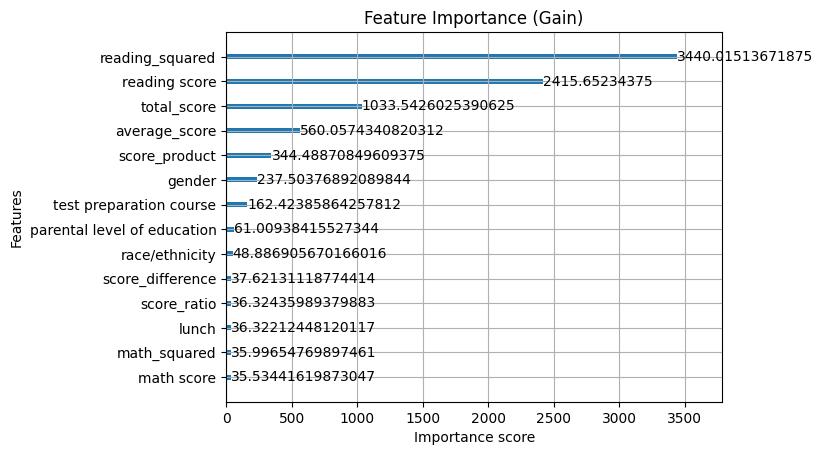

In [ ]:
param_grid = {
  'n_estimators': [200, 300, 400, 500],  
    'learning_rate': [0.01, 0.03, 0.05, 0.1],  
    'max_depth': [3, 4, 5, 6, 7],  
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_lambda': [0, 0.5, 1, 5, 10],  
    'reg_alpha': [0, 0.1, 0.5, 1],  
    'min_child_weight': [1, 3, 5]
}


kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=41, enable_categorical=True, tree_method='hist'),
    param_distributions = param_grid,
    n_iter = 100,  
    scoring = 'r2',
    cv=kfold,
    random_state=42,
    n_jobs = -1,
    verbose = 1
)

random_search.fit(X_train_final, y_train)
best_model = random_search.best_estimator_
print(f"Best CV R² Score: {random_search.best_score_:.4f}")
print(f"Best Parameters: {random_search.best_params_}")

y_pred_train = best_model.predict(X_train_final)
y_pred_test = best_model.predict(X_test_final)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = root_mean_squared_error(y_test, y_pred_test)

print("\n--- Performance Comparison ---")
print(f"Baseline Test R²:     {baseline_test_r2:.4f}")
print(f"Tuned Model Test R²:  {test_r2:.4f}")
print(f"Improvement:          {test_r2 - baseline_test_r2:.4f}")

print("\n--- Final Model Metrics ---")
print(f"Train R²:  {train_r2:.4f}")
print(f"Test R²:   {test_r2:.4f}")
print(f"Test MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

importances = best_model.feature_importances_

plot_importance(best_model, importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.show()